In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
os.getcwd()

'/Users/yingchen/Documents2/CASA/urban_simulation/practical/wk7/Week_7_final'

In [3]:
os.chdir("./underground")
g_shp=nx.read_shp('underground.shp',geom_attrs=False) 

In [4]:
# original *undirected* network
g_shp=nx.read_shp('underground.shp',geom_attrs=False) 

nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp,nod_all,'station')

g_shp_un = g_shp.to_undirected()

In [5]:
print(nx.info(g_shp_un))

Name: 
Type: Graph
Number of nodes: 306
Number of edges: 353
Average degree:   2.3072


## Explore the network

In [6]:
# 1. maximum distance between stations
max_edge=max(dict(g_shp_un.edges).items(), key=lambda x: x[1]['distance'])
max_edge

(((-0.1803, 51.5472), (-0.2795, 51.5635)),
 {'toid_seq': '240',
  'station_1': 94,
  'station_1_': 'Finchley Road',
  'station_2': 282,
  'station_2_': 'Wembley Park',
  'distance': 7115.148277461,
  'ShpName': 'underground'})

In [7]:
# 2. stations directly connected to *any known* station
Baker = [(d['station_1_'],d['station_2_']) for  u,v,d in g_shp_un.edges(data=True) 
         if "Baker" in d['station_1_'] or "Baker" in d['station_2_']]
Baker

[('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Edgware Road (C)'),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Bond Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Finchley Road')]

In [8]:
# 3. edges directly connected to *any known* station
Baker = [(u,v,d) for  u,v,d in g_shp_un.edges(data=True) 
         if "Baker" in d['station_1_'] or "Baker" in d['station_2_']]
#Baker

In [9]:
# 4. unweighted diameter
nx.diameter(g_shp_un)

38

In [10]:
# 5. weighted (distance) diameter
nlen = {n:nx.single_source_dijkstra_path_length(g_shp_un, n, weight='distance') 
        for n in g_shp_un.nodes() }
e = nx.eccentricity(g_shp_un,sp=nlen)
d = nx.diameter(g_shp_un, e)
d

71491.11880904001

In [11]:
# 6. global eff
eff = nx.global_efficiency(g_shp_un)
eff

0.1021247523344587

In [12]:
# 7. LCC
# connected components sorted from largest to smallest
[len(c) for c in sorted(nx.connected_components(g_shp_un), key=len, reverse=True)]

[306]

### Closeness centrality (weighted)

In [13]:
#Weighted closeness centrality: 
clos_w=nx.closeness_centrality(g_shp_un, distance='distance')
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un,clos_w,'closeness_w')

CC = pd.DataFrame.from_dict(clos_w,columns=['closeness_w'],orient='index')
CC.sort_values(by=['closeness_w'],ascending=False)[:10]

,closeness_w
"(-0.1415, 51.515)",0.000089
"(-0.131, 51.5165)",0.000089
"(-0.1342, 51.5098)",0.000088
"(-0.12, 51.5174)",0.000088
"(-0.1281, 51.5113)",0.000088
"(-0.1494, 51.5142)",0.000088
"(-0.1428, 51.5067)",0.000088
"(-0.1247, 51.508)",0.000088
"(-0.1223, 51.5074)",0.000088
"(-0.1243, 51.5129)",0.000087


In [14]:
# the top 10 stations with the maximum closeness centrality values
maxclose10=CC.sort_values(by=['closeness_w'],ascending=False)[:10]
maxclose10 = maxclose10.index.tolist()
for i in maxclose10:
    print(g_shp_un.nodes[i]['station'])

Oxford Circus
Tottenham Court Road
Picadilly Circus
Holborn
Leicester Square
Bond Street
Green Park
Charing Cross
Embankment
Covent Garden


In [15]:
l1=list(g_shp_un.nodes)
len(l1)

306

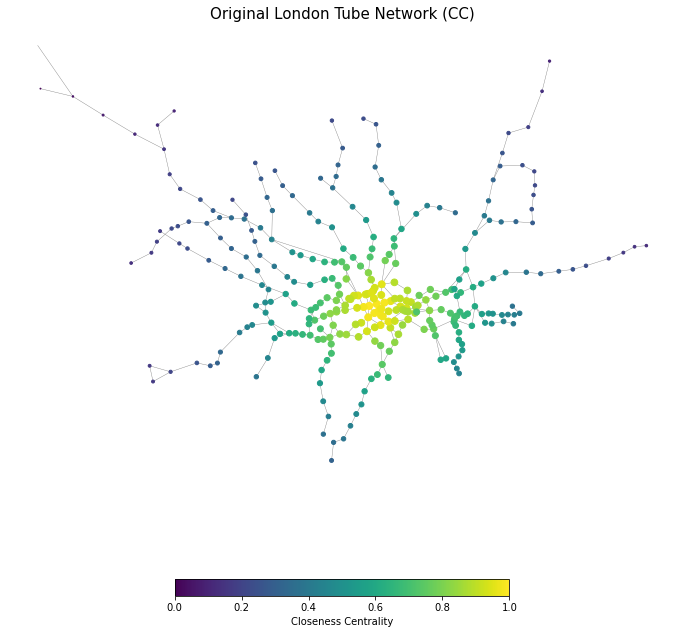

<Figure size 432x288 with 0 Axes>

In [16]:
# original clossessness centrality 
clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in g_shp_un.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in g_shp_un.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
pos_shp = {xy: xy for xy in g_shp.nodes()}
pos=pos_shp

nx.draw_networkx_edges(g_shp_un, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Original London Tube Network (CC)",fontsize=15)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p1_CC1.png', dpi=100)

### non-sequential removel 

In [17]:
g_shp_un.remove_nodes_from(maxclose10)

In [18]:
# Existing nodes:
l2=list(g_shp_un.nodes)
len(l2)

296

In [19]:
# to check which is the one missing:
list(set(l1) - set(l2))

[(-0.1247, 51.508),
 (-0.1428, 51.5067),
 (-0.1243, 51.5129),
 (-0.1494, 51.5142),
 (-0.1415, 51.515),
 (-0.12, 51.5174),
 (-0.1281, 51.5113),
 (-0.1342, 51.5098),
 (-0.1223, 51.5074),
 (-0.131, 51.5165)]

In [20]:
print(nx.info(g_shp_un))

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 326
Average degree:   2.2027


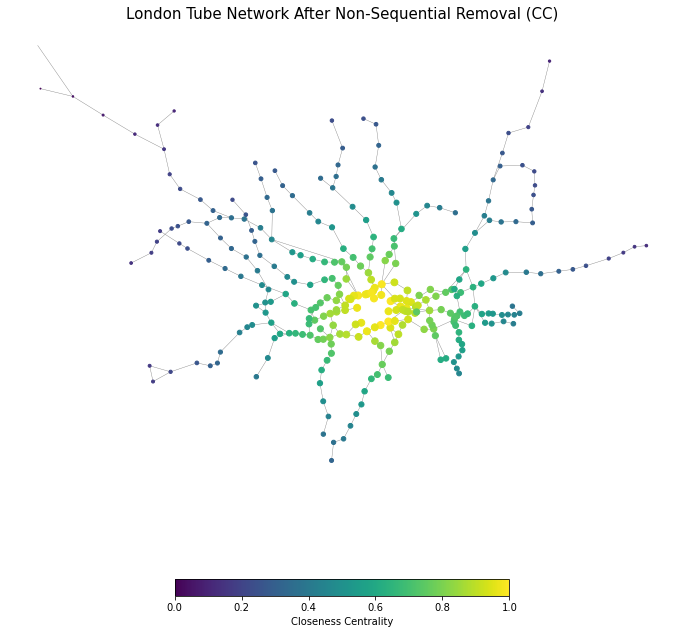

<Figure size 432x288 with 0 Axes>

In [21]:
# plot
clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in g_shp_un.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in g_shp_un.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
pos_shp = {xy: xy for xy in g_shp.nodes()}
pos=pos_shp

nx.draw_networkx_edges(g_shp_un, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube Network After Non-Sequential Removal (CC)",fontsize=15)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p1_CC2.png', dpi=100)

In [29]:
print(nx.info(g_shp_un))

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 326
Average degree:   2.2027


In [22]:
# 1. connected components sorted from largest to smallest
len([len(c) for c in sorted(nx.connected_components(g_shp_un), key=len, reverse=True)])

1

In [23]:
# 2. Generate connected components and select the largest:
largest_component = max(nx.connected_components(g_shp_un), key=len)

# Create a subgraph of G consisting only of this component:
G = g_shp_un.subgraph(largest_component)

In [24]:
# 3.
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 326
Average degree:   2.2027


In [25]:
# 4. unweighted diameter
nx.diameter(G)

38

In [26]:
# 5. weighted (distance) diameter
nlen = {n:nx.single_source_dijkstra_path_length(G, n, weight='distance') 
        for n in G.nodes() }
e = nx.eccentricity(G,sp=nlen)
d = nx.diameter(G, e)
d

71491.11880904001

In [27]:
# 6. global eff
eff = nx.global_efficiency(G)
eff

0.09509272916964234

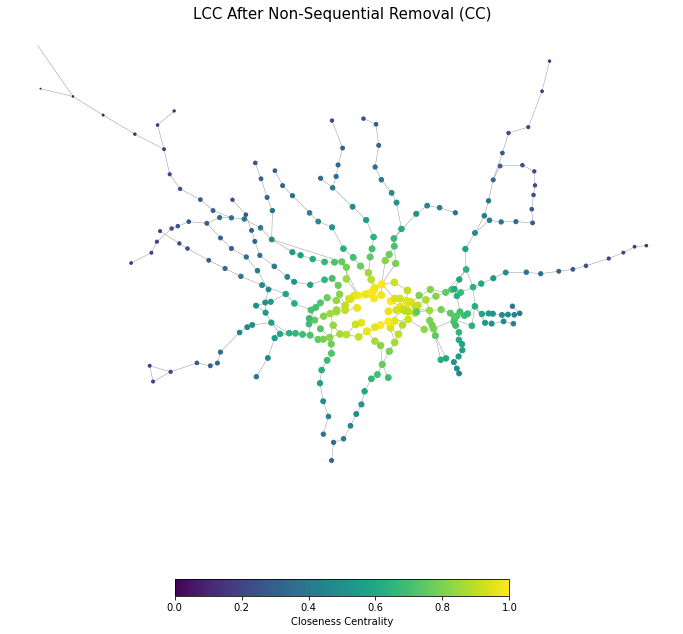

<Figure size 432x288 with 0 Axes>

In [28]:
clos_w=nx.closeness_centrality(G, distance='distance')
nx.set_node_attributes(G,clos_w,'closesness_w')

# plot
clos_w_val=[(i[1]['closeness_w']) for i in G.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in G.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
pos_shp = {xy: xy for xy in g_shp_un.nodes()}
pos=pos_shp

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("LCC After Non-Sequential Removal (CC)",fontsize=15)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('p1_CC3.png', dpi=100)